In [1]:
%load_ext autoreload
%autoreload 2
import os
from cnbpy.datalad import DATASET,SUBJECT, ABIDE_DATASET
from cnbpy.bids import BIDS
from cnbpy.fmriprep import FMRIPREP
import cortex

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.


In [2]:
local_path='/storage/research/cinn_comp/nicktest2'

In [3]:
source='///abide2/RawData/GU_1'

In [5]:
DSET=ABIDE_DATASET(local_path,source)

The ABIDE subject class contains a list of subjects that have been fmriprepped.

In [6]:
DSET.fmriprepped_subs[:10]

['28682',
 '28684',
 '28685',
 '28688',
 '28696',
 '28702',
 '28703',
 '28704',
 '28707',
 '28708']

In [7]:
from cnbpy.datalad import ABIDE_SUBJECT

Here I set up an ABIDE subject

In [8]:
msub=ABIDE_SUBJECT(DSET,'50007','/storage/research/cinn_comp/DATA/ABIDE_FMRIPREP')

We can view the fmriprep report (including surface reconstruction) as follows.

In [23]:
msub.show_report(msub.fmriprep_report)

<IPython.core.display.Javascript object>

Stopping server


This is a little complicated. Essentially - because the fmriprep data is stored on S3, but isnt a datalad dataset, we need to use a datalad crawler to turn it into a datalad dataset.

In [10]:
msub.get_fmriprep_data()

[INFO] Loading pipeline specification from ./.datalad/crawl/crawl.cfg 
[INFO] Creating a pipeline for the fcp-indi bucket 
[WARNING] ATM we assume prefixes to correspond only to directories, adding / 
[INFO] Running pipeline [<datalad_crawler.nodes.s3.crawl_s3 object at 0x2b4143b757f0>, switch(default=None, key='datalad_action', mapping=<<{'commit': <fu++328 chars++8>>}>>, re=False)] 
[INFO] S3 session: Connecting to the bucket fcp-indi anonymously 
[INFO] Finished running pipeline: skipped: 64 
[INFO] Total stats: skipped: 64,  Datasets crawled: 1 


Because the fmriprep stuff is also BIDS formatted we can leverage the BIDS stuff to see what tasks and session there are. 

In [11]:
msub.bids.elaborate()
msub.get_sess_run_combs()

Found 1 participant(s) ['50007']
["Found 2 session(s) for sub-50007 ['1', '2']"]
["Found 1 task(s) for sub-50007 and ses-1 ['rest']", "Found 1 task(s) for sub-50007 and ses-2 ['rest']"]
/storage/research/cinn_comp/DATA/ABIDE_FMRIPREP/sub-50007/fmriprep/sub-50007/ses-1/func
/storage/research/cinn_comp/DATA/ABIDE_FMRIPREP/sub-50007/fmriprep/sub-50007/ses-2/func


These are combinations of sessions and runs that the subject has. 

In [12]:
msub.sess_run_combs

[['1', '1'], ['2', '1']]

We can pass this to the 'load_fmriprep_outcomes' method to get the fsaverage5-sampled resting state data. 

Here, for instance, we load in the data from session 1, run 1.

In [13]:
dat=msub.load_fmriprep_outcomes(*msub.sess_run_combs[0])

ses-1/func/sub-50007_ses-1_task-rest_run-1_space-fsaverage5_hemi-L.func.gii ses-1/func/sub-50007_ses-1_task-rest_run-1_space-fsaverage5_hemi-R.func.gii


In [14]:
dat.shape

(20484, 200)

It has 20484 vertices and 200 volumes.

We can use pycortex for some visualisation.

In [15]:
import cortex

First, make a movie of the zscored timseries data - show this in a webviewer.

In [16]:
from scipy import stats
zdat=stats.zscore(dat,axis=1)
zd=cortex.Vertex(zdat.T,subject='fsaverage5')

/home/users/yg916972/.conda/envs/p3env/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [17]:
cortex.webshow(zd)

Started server on port 25312


<JS: window.viewer>

Now show a flatmap of tsnr, for instance.

In [22]:
msub.anatrow

Site_ID                                       ABIDEII-UPSM_Long
Sub_ID                                                    50007
Session                                                baseline
Series                                                   anat_1
Unique_ID               ABIDEII-UPSM_Long_50007_baseline_anat_1
CNR                                                     9.63887
SNR                                                     16.0899
Qi1                                                    0.227461
EFC                                                     0.49763
Smoothness_of_Voxels                                    4.09413
FBER                                                    221.622
Cortical Contrast                                      0.356471
Name: 1328, dtype: object

In [18]:
import numpy as np
def compute_tsnr(data):
    tsnr = np.mean(data,axis=-1)/np.std(data,axis=-1)
    return tsnr

In [19]:
tsnr=compute_tsnr(dat)

/home/users/yg916972/.conda/envs/p3env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


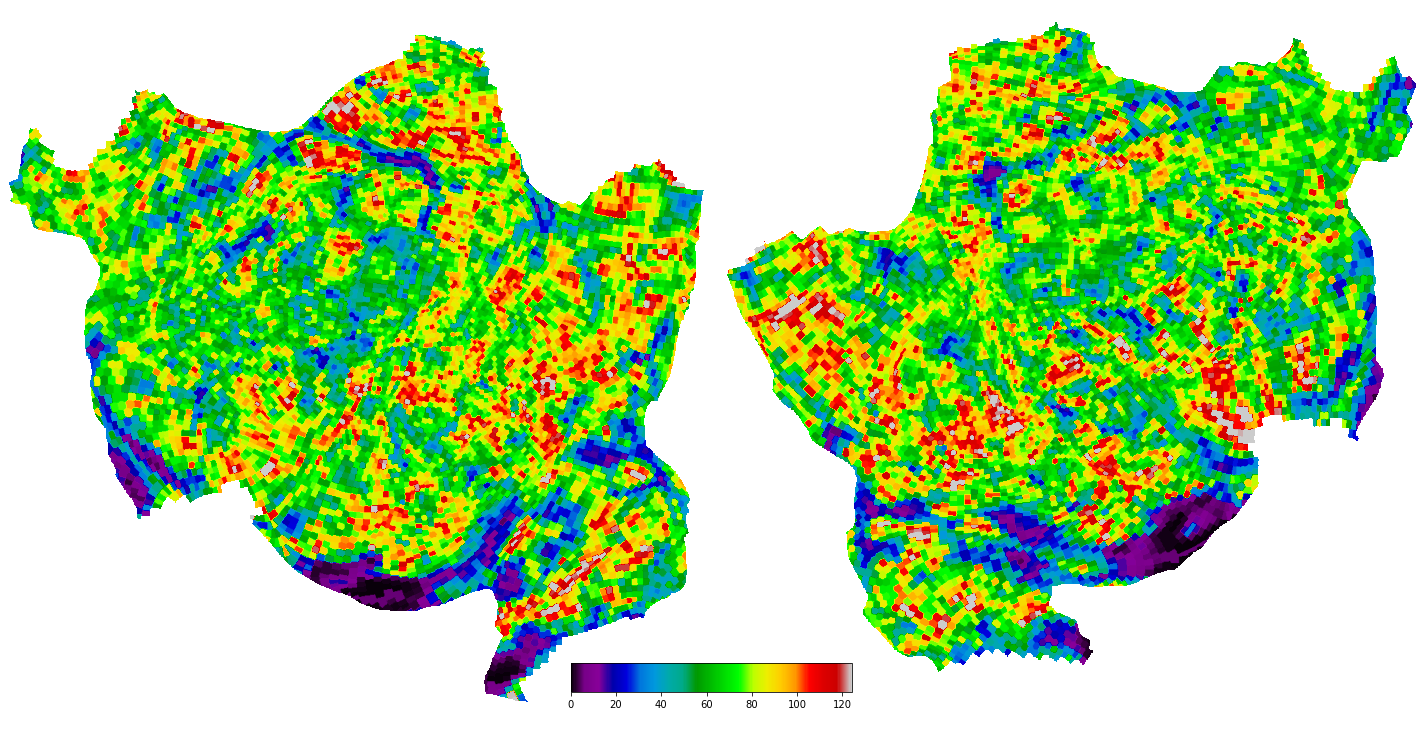

In [20]:
mdat=cortex.Vertex(tsnr,subject='fsaverage5',cmap='nipy_spectral')
mp=cortex.quickshow(mdat,vmin=np.nanmin(mdat),vmax=np.nanmax(mdat),with_rois=False)

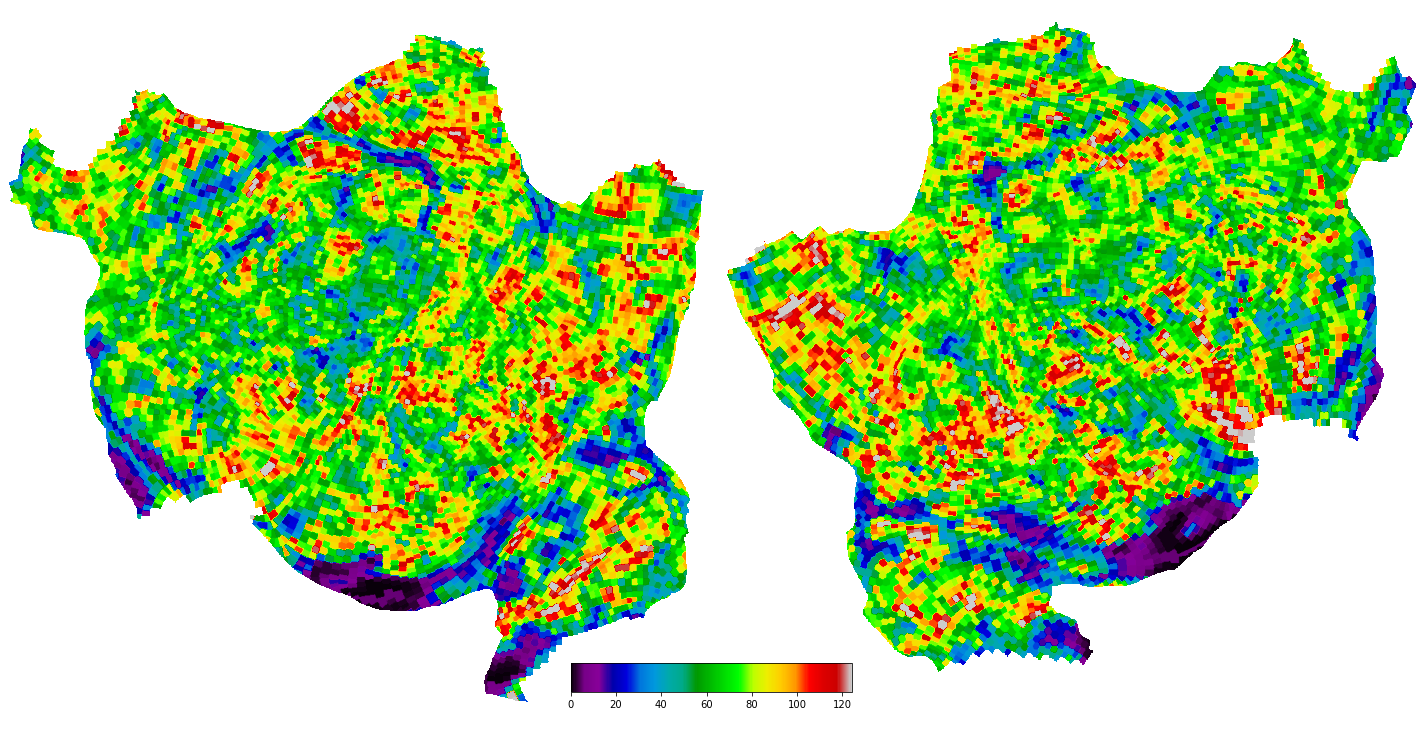

In [25]:
mp=cortex.quickshow(mdat,vmin=np.nanmin(mdat),vmax=np.nanmax(mdat),with_rois=False)

Viola